In [7]:
from IPython.display import Image

In [6]:
# TODAY: just testing which is better: emcee, pystan, pymc

# TEST PROBLEM: line of best fit for 3-parameter model. 
# parameters: slope, intercept, scatter about the line (is a nuisance
# parameter). 


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

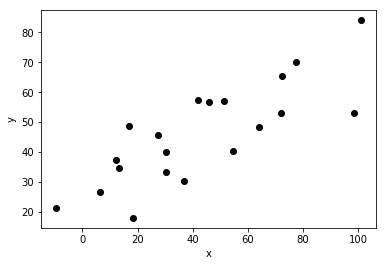

In [2]:
plt.gcf().set_facecolor("white")
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

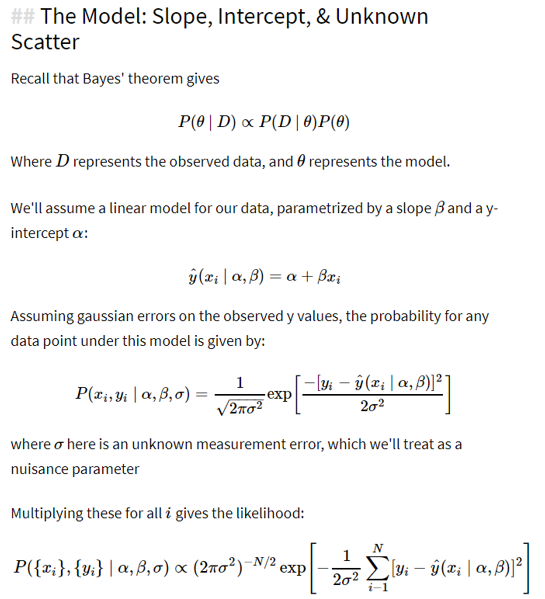

In [8]:
Image(filename="images/4_model.png")

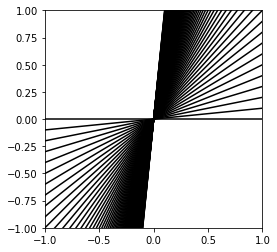

In [4]:
# Showing why a flat prior on alpha, beta, and sigma is bad:
# flat priors aren't necessarily uninformative. 
# Better use Jeffreys and symmetry or max entropy. 

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

plt.gcf().set_facecolor("white")
for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');

In [ ]:
# These lines have evenly-spaced slopes in units of 0.1, 
# yet the higher slopes are bunched together. With a flat prior, 
# you're essentially saying that any one of these slopes is just 
# as likely as another. Due to this bunching seen above, it's clear 
# that a flat prior on slope will highly favor very steep slopes! 
# A flat prior on slope is not a minimally informative prior, and 
# may end up biasing your result (though with enough data the effect 
# is almost zero).

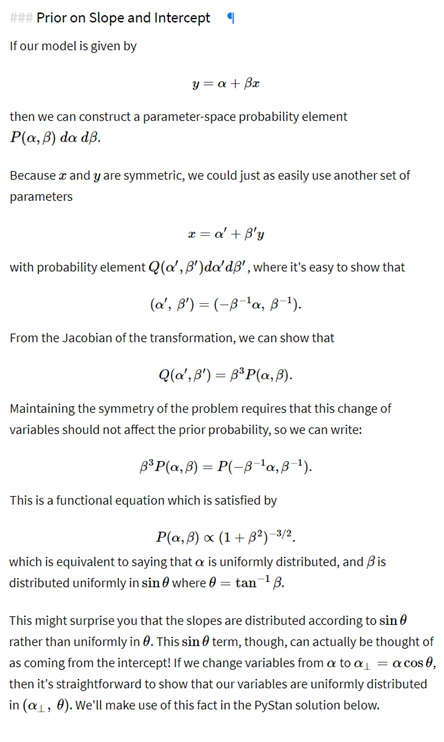

In [10]:
Image(filename="images/4_prior1.png")

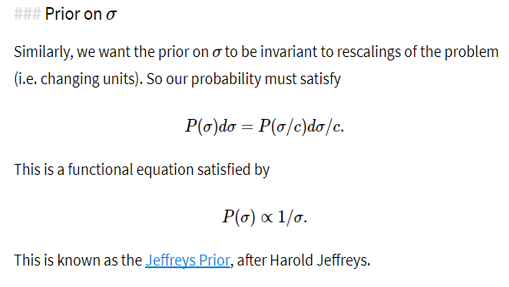

In [11]:
Image(filename="images/4_prior2.png")

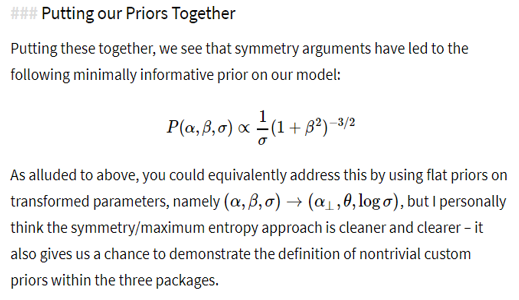

In [12]:
Image(filename="images/4_prior3.png")

In [20]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    plt.gcf().set_facecolor("white")
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')


def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    plt.gcf().set_facecolor("white")
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    plt.gcf().set_facecolor("white")
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

In [14]:
# EMCEE -----------------------------------------------


import emcee

# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + 
                         (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [15]:
# Here we'll set up the computation. emcee combines multiple 
# "walkers",
# each of which is its own MCMC chain. The number of trace 
# results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [16]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[xdata, ydata])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 7.06 s, sys: 51.3 ms, total: 7.11 s
Wall time: 7.41 s
done


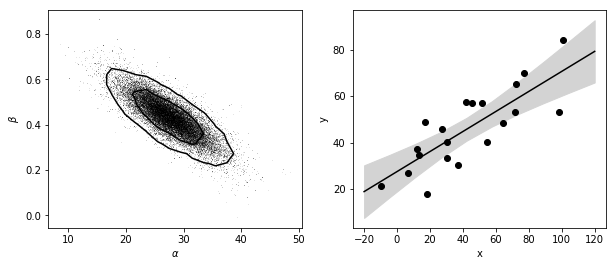

In [21]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T


plot_MCMC_results(xdata, ydata, emcee_trace)

In [ ]:
# On the left we show the resulting traces marginalized over the 
# nuisance parameter σσ. On the right, we show the line of best-fit 
# along with the 2-σσ uncertainty region. This is exactly the type 
# of result we expect from MCMC: marginalized uncertainty contours 
# around a model which provides a good by-eye fit to the data.

In [28]:
# PYMC ----------------------------------------

import pymc


# Define the variables needed for the routine, with their prior distributions
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, 
                observed=True, value=ydata)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma,
              y_model=y_model, y=y)

In [29]:
# run the basic MCMC: we'll do 100000 iterations to match emcee above
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)

 [                  0%                  ] 514 of 100000 complete in 0.5 sec

 [                  2%                  ] 2046 of 100000 complete in 1.0 sec

 [-                 3%                  ] 3893 of 100000 complete in 1.5 sec

 [--                5%                  ] 5742 of 100000 complete in 2.0 sec

 [--                7%                  ] 7137 of 100000 complete in 2.5 sec

 [---               8%                  ] 8940 of 100000 complete in 3.0 sec

 [----             10%                  ] 10646 of 100000 complete in 3.5 sec

 [----             12%                  ] 12502 of 100000 complete in 4.0 sec

 [-----            14%                  ] 14173 of 100000 complete in 4.5 sec

 [------           15%                  ] 15987 of 100000 complete in 5.0 sec

 [------           17%                  ] 17328 of 100000 complete in 5.5 sec

 [------           17%                  ] 17928 of 100000 complete in 6.0 sec

 [-------          18%                  ] 18503 of 100000 complete in 6.5 sec

 [-------          19%                  ] 19006 of 100000 complete in 7.0 sec

 [-------          19%                  ] 19891 of 100000 complete in 7.5 sec

 [--------         21%                  ] 21461 of 100000 complete in 8.0 sec

 [--------         23%                  ] 23427 of 100000 complete in 8.5 sec

 [---------        25%                  ] 25222 of 100000 complete in 9.0 sec

 [----------       27%                  ] 27097 of 100000 complete in 9.5 sec

 [----------       28%                  ] 28692 of 100000 complete in 10.0 sec

 [-----------      29%                  ] 29417 of 100000 complete in 10.5 sec

 [-----------      31%                  ] 31011 of 100000 complete in 11.0 sec

 [------------     32%                  ] 32956 of 100000 complete in 11.5 sec

 [-------------    34%                  ] 34773 of 100000 complete in 12.0 sec

 [-------------    36%                  ] 36339 of 100000 complete in 12.5 sec

 [--------------   37%                  ] 37365 of 100000 complete in 13.0 sec

 [--------------   39%                  ] 39186 of 100000 complete in 13.5 sec

 [---------------  41%                  ] 41054 of 100000 complete in 14.0 sec

 [---------------- 42%                  ] 42941 of 100000 complete in 14.5 sec

 [---------------- 44%                  ] 44727 of 100000 complete in 15.0 sec

 [-----------------46%                  ] 46564 of 100000 complete in 15.5 sec

 [-----------------48%                  ] 48282 of 100000 complete in 16.0 sec

 [-----------------49%                  ] 49941 of 100000 complete in 16.5 sec

 [-----------------50%                  ] 50788 of 100000 complete in 17.0 sec

 [-----------------51%                  ] 51219 of 100000 complete in 17.5 sec

 [-----------------51%                  ] 51772 of 100000 complete in 18.0 sec

 [-----------------52%                  ] 52691 of 100000 complete in 18.5 sec

 [-----------------54%                  ] 54266 of 100000 complete in 19.0 sec

 [-----------------55%-                 ] 55294 of 100000 complete in 19.5 sec

 [-----------------56%-                 ] 56756 of 100000 complete in 20.0 sec

 [-----------------57%--                ] 57925 of 100000 complete in 20.5 sec

 [-----------------58%--                ] 58394 of 100000 complete in 21.0 sec

 [-----------------58%--                ] 58801 of 100000 complete in 21.5 sec

 [-----------------59%--                ] 59269 of 100000 complete in 22.0 sec

 [-----------------59%--                ] 59916 of 100000 complete in 22.5 sec

 [-----------------60%---               ] 60715 of 100000 complete in 23.0 sec

 [-----------------61%---               ] 61308 of 100000 complete in 23.5 sec

 [-----------------62%---               ] 62059 of 100000 complete in 24.0 sec

 [-----------------62%---               ] 62591 of 100000 complete in 24.5 sec

 [-----------------63%----              ] 63796 of 100000 complete in 25.0 sec

 [-----------------65%----              ] 65419 of 100000 complete in 25.5 sec

 [-----------------66%-----             ] 66799 of 100000 complete in 26.0 sec

 [-----------------68%-----             ] 68335 of 100000 complete in 26.5 sec

 [-----------------69%------            ] 69081 of 100000 complete in 27.0 sec

 [-----------------69%------            ] 69496 of 100000 complete in 27.5 sec

 [-----------------70%------            ] 70094 of 100000 complete in 28.0 sec

 [-----------------70%------            ] 70566 of 100000 complete in 28.5 sec

 [-----------------71%------            ] 71005 of 100000 complete in 29.0 sec

 [-----------------71%-------           ] 71803 of 100000 complete in 29.5 sec

 [-----------------72%-------           ] 72409 of 100000 complete in 30.0 sec

 [-----------------72%-------           ] 72942 of 100000 complete in 30.5 sec

 [-----------------73%-------           ] 73446 of 100000 complete in 31.0 sec

 [-----------------73%--------          ] 73981 of 100000 complete in 31.5 sec

 [-----------------74%--------          ] 74728 of 100000 complete in 32.0 sec

 [-----------------76%--------          ] 76222 of 100000 complete in 32.5 sec

 [-----------------77%---------         ] 77891 of 100000 complete in 33.0 sec

 [-----------------79%----------        ] 79571 of 100000 complete in 33.5 sec

 [-----------------80%----------        ] 80904 of 100000 complete in 34.0 sec

 [-----------------82%-----------       ] 82406 of 100000 complete in 34.5 sec

 [-----------------83%-----------       ] 83884 of 100000 complete in 35.0 sec

 [-----------------85%------------      ] 85488 of 100000 complete in 35.5 sec

 [-----------------87%-------------     ] 87033 of 100000 complete in 36.0 sec

 [-----------------88%-------------     ] 88593 of 100000 complete in 36.5 sec

 [-----------------90%--------------    ] 90153 of 100000 complete in 37.0 sec

 [-----------------91%--------------    ] 91101 of 100000 complete in 37.5 sec

 [-----------------92%---------------   ] 92182 of 100000 complete in 38.0 sec

 [-----------------93%---------------   ] 93761 of 100000 complete in 38.5 sec

 [-----------------95%----------------  ] 95309 of 100000 complete in 39.0 sec

 [-----------------96%----------------  ] 96871 of 100000 complete in 39.5 sec

 [-----------------98%----------------- ] 98263 of 100000 complete in 40.0 sec

 [-----------------99%----------------- ] 99788 of 100000 complete in 40.5 sec

 [-----------------100%-----------------] 100000 of 100000 complete in 40.6 sec

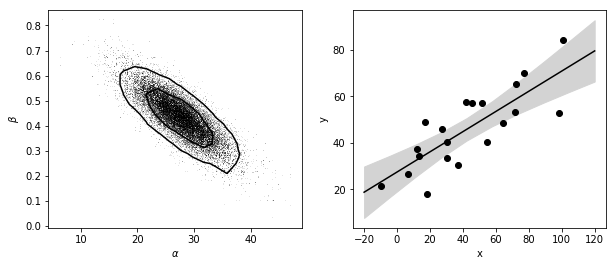

In [30]:
# extract the traces and plot the results
pymc_trace = [S.trace('alpha')[:],
              S.trace('beta')[:],
              S.trace('sigma')[:]]

plot_MCMC_results(xdata, ydata, pymc_trace)

# Observe: We get traces very similar to those provided by emcee.

In [31]:
# PYSTAN -----------------------------------------------------

import pystan


# Create the Stan model
#  this is done by defining a string of Stan code.

fit_code = """
data {
    int<lower=0> N; // number of points
    real x[N]; // x values
    real y[N]; // y values
}

parameters {
    real alpha_perp;
    real<lower=-pi()/2, upper=pi()/2> theta;
    real log_sigma;
}

transformed parameters {
    real alpha;
    real beta;
    real sigma;
    real ymodel[N];
    
    alpha <- alpha_perp / cos(theta);
    beta <- sin(theta);
    sigma <- exp(log_sigma);
    for (j in 1:N)
    ymodel[j] <- alpha + beta * x[j];
}

model {
    y ~ normal(ymodel, sigma);
}
"""

# perform the fit
fit_data = {'N': len(xdata), 'x': xdata, 'y': ydata}
fit = pystan.stan(model_code=fit_code, data=fit_data, iter=25000, chains=4)

# extract the traces
traces = fit.extract()
pystan_trace = [traces['alpha'], traces['beta'], traces['sigma']]

# save the traces with numpy
np.save("pystan_trace.npy", pystan_trace)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1dba2ed7f485b674d7ce5eb738ffe05 NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++ [enabled by default]
In file included from /datascience/bin/python/anaconda3/envs/bayes/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1777:0,
                 from /datascience/bin/python/anaconda3/envs/bayes/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /datascience/bin/python/anaconda3/envs/bayes/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpuy7k7stj/stanfit4anon_model_c1dba2ed7f485b674d7ce5eb738ffe05_1751574976707255928.cpp:553:
/datascience/bin/python/anaconda3/envs/bayes/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /datas

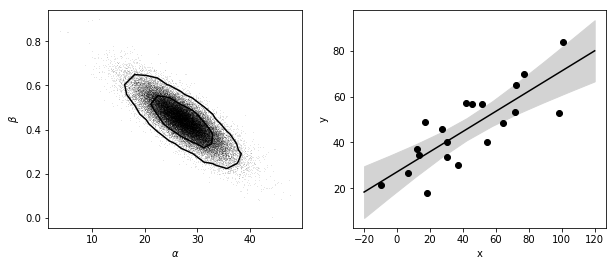

In [32]:
# load the results from file; plot as above
pystan_trace = np.load('pystan_trace.npy')
plot_MCMC_results(xdata, ydata, pystan_trace)

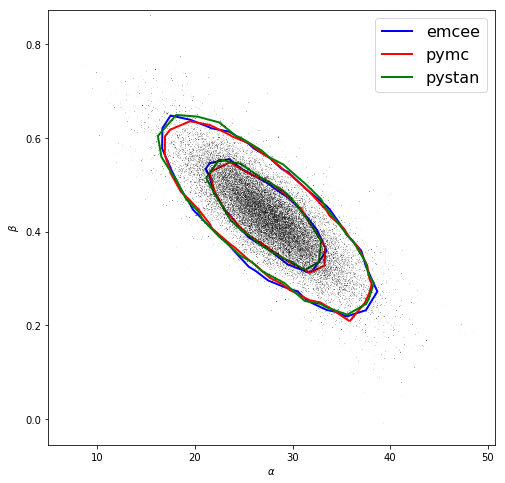

In [35]:
# Summary: Comparing the Three Methods


fig, ax = plt.subplots(figsize=(8, 8))
plot_MCMC_trace(ax, xdata, ydata, emcee_trace, True,
                colors='blue', linewidths=2)
plot_MCMC_trace(ax, xdata, ydata, pymc_trace,
                colors='red', linewidths=2)
plot_MCMC_trace(ax, xdata, ydata, pystan_trace,
                colors='green', linewidths=2)
ax.legend(ax.collections[::2], ['emcee', 'pymc', 'pystan'],
          fontsize=16);